<h1>Análisis de Sentimientos</h1>
    El objetivo es entrenar un modelo que analise si una review es buena o mala 


In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy

In [3]:
import spacy.cli
spacy.cli.download("pt_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 7.2 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import pt_core_news_sm
spc_pt = pt_core_news_sm.load()

<h2>Limpieza de datos<h2>

In [5]:
# Cargamos el Dataset de reviews
reviews= pd.read_csv("datasets/olist_order_reviews_dataset.csv").copy()

In [6]:
reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


In [7]:
#Eliminamos columnas innecesarias
reviews.drop(['order_id','review_creation_date','review_answer_timestamp'],axis=1, inplace= True, errors='ignore')

In [8]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               99224 non-null  object
 1   review_score            99224 non-null  int64 
 2   review_comment_title    11568 non-null  object
 3   review_comment_message  40977 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [9]:
duplicados = reviews.duplicated(subset='review_id').sum()

porcentaje_duplicados = duplicados/len(reviews)*100

print(f"Reviews con id duplicados: {porcentaje_duplicados}")
# solo el 0.82 % de los datos son duplicados por lo que no afectaría eliminarlos directamente 

Reviews con id duplicados: 0.8203660404740789


In [10]:
# Eliminamos duplicados
reviews.drop_duplicates('review_id',inplace=True)

In [11]:
# Unimos review_comment_title y review_comment_message para evitar las situaciones en las que una de las dos columnas no posea texto

reviews.fillna('',inplace=True) # Evita pproblemas con valores NaN rellenando con espacio vacío

reviews['review'] = reviews['review_comment_title'] + ' ' + reviews['review_comment_message'] # Creamos columna nueva donde se asigna la concatenación de las dos columnas deseadas

reviews = reviews[reviews['review'] != ' '] #En el caso de que review_title y review_message no tengan texto esta linea los elimina del dataset

In [12]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42389 entries, 3 to 99223
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42389 non-null  object
 1   review_score            42389 non-null  int64 
 2   review_comment_title    42389 non-null  object
 3   review_comment_message  42389 non-null  object
 4   review                  42389 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [13]:
reviews.head(10)

,review_id,review_score,review_comment_title,review_comment_message,review
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok..."
16,9314d6f9799f5bfba510cc7bcd468c01,2,,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...","GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI ..."
19,373cbeecea8286a2b66c97b1b157ec46,1,Não chegou meu produto,Péssimo,Não chegou meu produto Péssimo
22,d21bbc789670eab777d27372ab9094cc,5,Ótimo,Loja nota 10,Ótimo Loja nota 10
24,0e0190b9db53b689b285d3f3916f8441,5,,obrigado pela atençao amim dispensada,obrigado pela atençao amim dispensada
27,fe3db7c069d694bab50cc43463f91608,5,,A compra foi realizada facilmente.\r\nA entreg...,A compra foi realizada facilmente.\r\nA entre...


In [14]:
reviews['review_score'].value_counts()

review_score
5    21672
1     8723
4     6241
3     3615
2     2138
Name: count, dtype: int64

In [15]:
labels = []

for score in reviews['review_score']:
    if score > 3: # Si la puntuacion es mayor a 3 la consideramos positiva
        labels.append(1)
    else:
        labels.append(0) # Si la puntuacion es menor  3 la tomamos como negativa

reviews['label'] = labels

In [16]:
reviews.tail(10)

,review_id,review_score,review_comment_title,review_comment_message,review,label
99197,51de4e06a6b701cb2be47ea0e689437b,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,Não foi entregue o pedido Bom dia \r\nDas 6 un...,0
99199,40743b46a0ee86375cedb95e82b78d75,5,OTIMA EMBALAGEM,,OTIMA EMBALAGEM,1
99200,2ee221b28e5b6fceffac59487ed39348,2,Foto enganosa,Foto muito diferente principalmente a graninha...,Foto enganosa Foto muito diferente principalm...,0
99202,7047578adefcc7c27319e3cf91ba1416,5,,"Produto original,prazo de entrega rápido.Super...","Produto original,prazo de entrega rápido.Supe...",1
99203,5085bc489aa6b58a29c4f922d59ff826,2,,Tive um problema na entrega em que o correio c...,Tive um problema na entrega em que o correio ...,0
99205,98fffa80dc9acbde7388bef1600f3b15,4,,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a comp...,1
99208,df5fae90e85354241d5d64a8955b2b09,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo. O produto chegou em...,1
99215,a709d176f59bc3af77f4149c96bae357,3,,"O produto não foi enviado com NF, não existe v...","O produto não foi enviado com NF, não existe ...",0
99221,b3de70c89b1510c4cd3d0649fd302472,5,,"Excelente mochila, entrega super rápida. Super...","Excelente mochila, entrega super rápida. Supe...",1
99223,efe49f1d6f951dd88b51e6ccd4cc548f,1,,"meu produto chegou e ja tenho que devolver, po...","meu produto chegou e ja tenho que devolver, p...",0


<h2> Pre-procesamiento de texto<h2>

In [17]:
# Descarga un conjunto de listas de palabras vacías (“stopwords”) para distintos idiomas (inglés, español, portugués, etc.).
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebastian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Se asigna el conjuntos de palabras vacias("stopwords") a stopwords_pt
stopwords_pt = stopwords.words('portuguese')
stopwords_pt

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [19]:
stopwords_pt.remove('não')
stopwords_pt.remove('nem')
# Eliminamos palabras que pueden ser importantes para el analisis

In [20]:
# Funcion que recibe un texto y lo devuelve en minusculas, sin stopwords y lemanizado 
def limpia_texto(texto):

    texto = texto.lower()

    texto = re.sub(r"[\W\d_]+", " ",texto)

    texto = [pal for pal in texto.split() if pal not in stopwords_pt]

    spc_texto = spc_pt(" ".join(texto))
    tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in spc_texto]

    return " ".join(tokens)

In [21]:
reviews['review'] = reviews['review'].apply(limpia_texto)

In [22]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42389 entries, 3 to 99223
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42389 non-null  object
 1   review_score            42389 non-null  int64 
 2   review_comment_title    42389 non-null  object
 3   review_comment_message  42389 non-null  object
 4   review                  42389 non-null  object
 5   label                   42389 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.3+ MB


In [23]:
reviews.head(10)

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipular,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,parabéns loja lannister adorar comprar Interne...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendar aparelho eficiente site marca apare...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travar valor ta bom,1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",super recomendo vendedor confiável produto ok ...,1
16,9314d6f9799f5bfba510cc7bcd468c01,2,,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",gostar saber sempre recebi compra agora decpci...,0
19,373cbeecea8286a2b66c97b1b157ec46,1,Não chegou meu produto,Péssimo,não chegar produto péssimo,0
22,d21bbc789670eab777d27372ab9094cc,5,Ótimo,Loja nota 10,bom loja noto,1
24,0e0190b9db53b689b285d3f3916f8441,5,,obrigado pela atençao amim dispensada,obrigar atençao amim dispensar,1
27,fe3db7c069d694bab50cc43463f91608,5,,A compra foi realizada facilmente.\r\nA entreg...,compra realizar facilmente entregar efetuar an...,1


In [24]:
reviews[reviews['review']== ""]

,review_id,review_score,review_comment_title,review_comment_message,review,label
297,2b4a570df87cd63b232272dd9dcac0cf,5,,A,,1
463,3140a4eb146655fe104d54d385f9e9a0,5,,10,,1
583,3814f35a6ebd64d27e2130f30ec05255,4,5,,,1
598,057c9a1e8e767d8bf6fa59ac43a82435,4,4,,,1
939,8f965d010b3119d9962e091de3425fb9,4,,*******************,,1
...,...,...,...,...,...,...
94778,014f70270fa59804f14eb3df2ca690d2,5,,........................,,1
96770,47850e2adbd18f61f2af4af9b7656198,5,,👍🏻👌🏻👏🏻,,1
97441,e47fd0401fce7a7b6283da2a5a8ba563,5,10,,,1
98032,f004d8b3a2ff22e3c030285842cf629a,5,*****,,,1


In [25]:
reviews = reviews[reviews['review']!= ''] # Eliminamos las reviews 'vacias'

In [26]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42129 entries, 3 to 99223
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42129 non-null  object
 1   review_score            42129 non-null  int64 
 2   review_comment_title    42129 non-null  object
 3   review_comment_message  42129 non-null  object
 4   review                  42129 non-null  object
 5   label                   42129 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

**TF-IDF**(term frequency - inverse document frequency) <br>
    **TF** ---> Importancia dentro del texto<br>
    **IDF** ---> Rartidad en el corpus<br>
    **TF-IDF** ---> Pondera ambas para resaltar palabras informativas<br>
    **resultado** ---> Matriz numerica lista para modelos ML

In [28]:
tfidf_vect = TfidfVectorizer(max_features=5000)

texto = reviews['review']

X_tfidf = tfidf_vect.fit_transform(texto)

In [29]:
print(X_tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 286560 stored elements and shape (42129, 5000)>
  Coords	Values
  (0, 1677)	0.6836843212234234
  (0, 3525)	0.3007123525754108
  (0, 302)	0.34731359832784564
  (0, 530)	0.4216662787174378
  (0, 3887)	0.3791024185243098
  (1, 1816)	0.3407586321337145
  (1, 4604)	0.23963042575240015
  (1, 3714)	0.37165246699584825
  (1, 4285)	0.35012262356651386
  (1, 2361)	0.35231044886098833
  (1, 929)	0.21821850298543746
  (1, 91)	0.24785614829751454
  (1, 2448)	0.23170363263908658
  (1, 2560)	0.1988239792844036
  (1, 3202)	0.4892414742594242
  (2, 4841)	0.16947892465004746
  (2, 1102)	0.1670980692889253
  (2, 439)	0.25174838378567105
  (2, 3006)	0.23623402401385904
  (2, 3146)	0.1458385516860155
  (2, 800)	0.09458202994246222
  (2, 2245)	0.30510835770253636
  (2, 2696)	0.4424419185839536
  (2, 4366)	0.15140562933240992
  (2, 1449)	0.2083995614539586
  :	:
  (42126, 1582)	0.22136425119643108
  (42126, 4809)	0.2293833321955357
  (42126, 1833)

<h2>Entrenamiento

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf, reviews['label'], test_size=0.3, random_state=42)

modelo = LogisticRegression()

modelo.fit(X_train, y_train)

LogisticRegression()

In [32]:
y_pred = modelo.predict(X_test)

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

In [34]:
def mostrar_metricas(y_true, y_pred):

    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("\nF1-score: ", f1_score(y_true, y_pred, average='weighted'))
    print("\nAUROC:", roc_auc_score(y_true, y_pred))
    print("\nMatriz de confusión:")
    sns.heatmap(confusion_matrix(y_true,y_pred), annot= True)
    plt.show()

Accuracy:  0.8995173668802912

F1-score:  0.8993178486344929

AUROC: 0.886432481852329

Matriz de confusión:


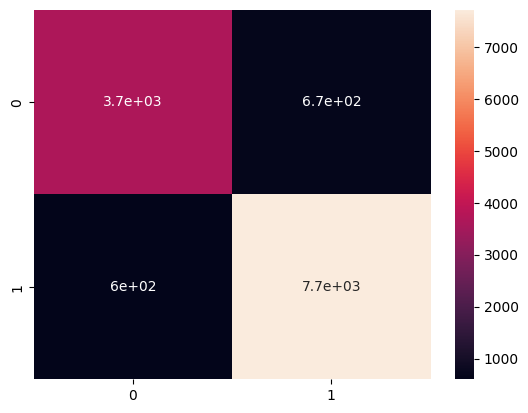

In [35]:
mostrar_metricas(y_test, y_pred)

In [36]:
from sklearn.ensemble import RandomForestClassifier

Accuracy:  0.8926339109106733

F1-score:  0.8929201881338694

AUROC: 0.8834785514174827

Matriz de confusión:


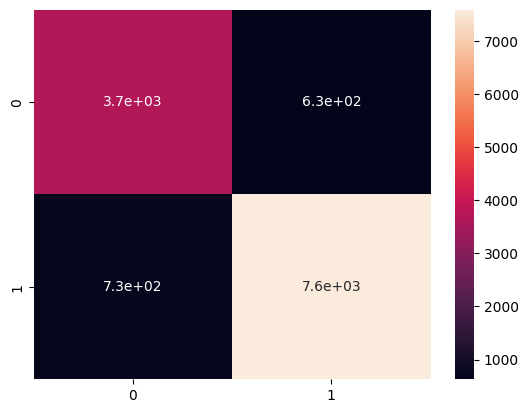

In [ ]:
rf = RandomForestClassifier(n_estimators= 200)

rf.fit(X_train,y_train)

y1_pred = rf.predict(X_test)

mostrar_metricas(y_test,y1_pred)

<h2> Visualización

In [38]:
from collections import Counter

negativos = reviews[reviews['label']== 0]['review']
palabras = " ".join(negativos).split()
conteo = Counter(palabras)

#Mostramos las mas comunes
print(conteo.most_common(15))

[('não', 9416), ('produto', 9135), ('entregar', 4235), ('recebi', 3374), ('vir', 2337), ('chegar', 2120), ('comprei', 1828), ('ainda', 1726), ('prazo', 1443), ('dia', 1381), ('pedir', 1368), ('bom', 1263), ('nao', 1221), ('compra', 1155), ('dois', 985)]


In [39]:
palabra = []
repeticion = []
for palabras, reps in conteo.most_common(20):
    palabra.append(palabras)
    repeticion.append(reps)

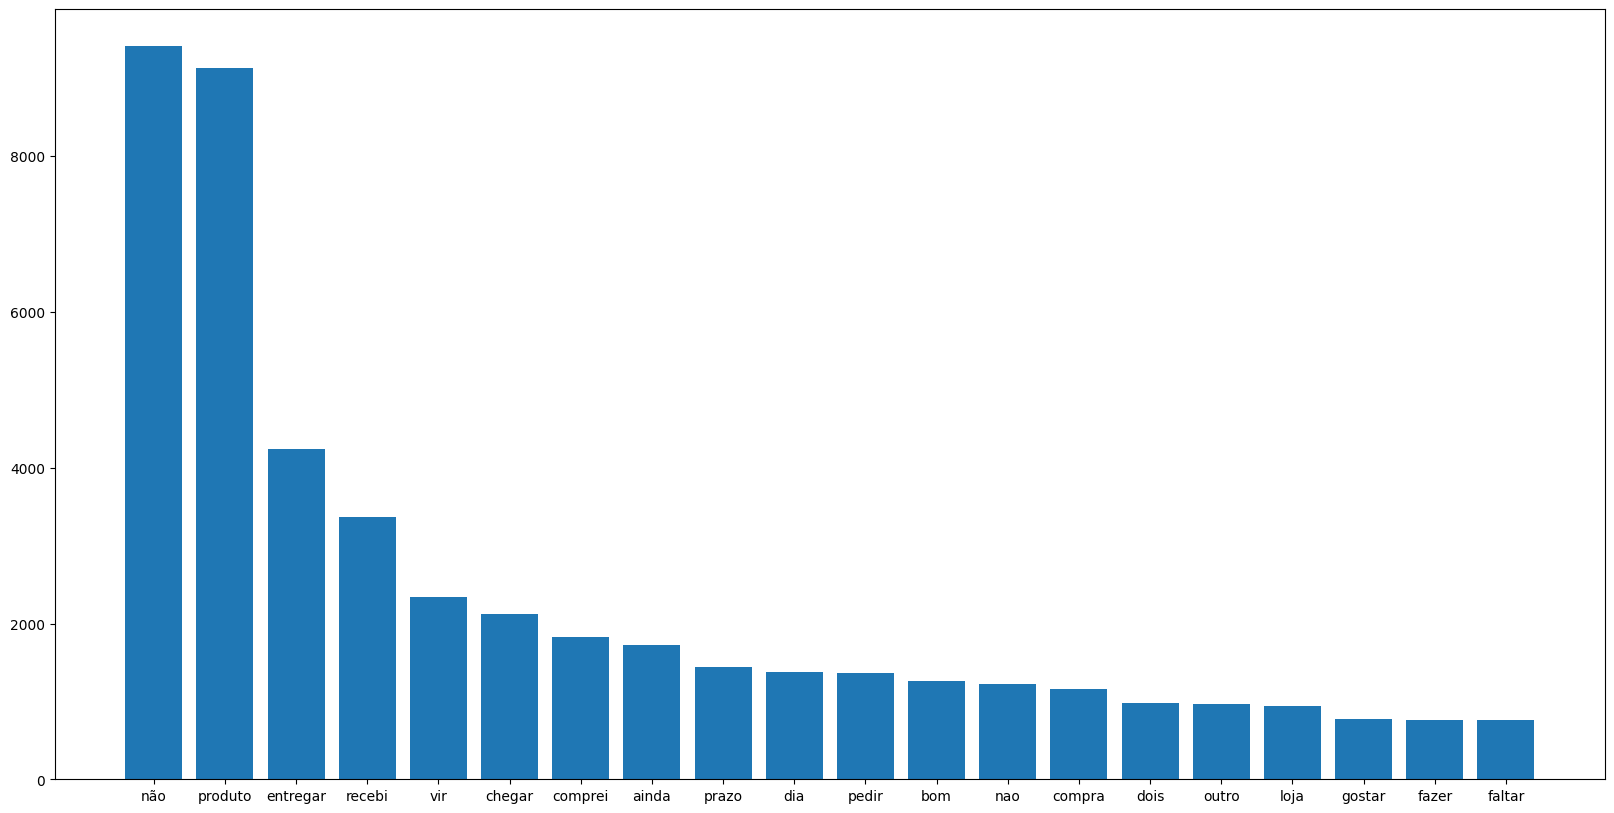

In [40]:
plt.figure(figsize=(20,10))
plt.bar(x= palabra, height= repeticion)
plt.show()

<h2>Conclusiones<h2>

El grafico nos muestra que muchas palabras hacen referecnia a problemas de envio, como entregar, chegar, prazo y mas recurrente 'nāo' que sugieren reviews con negación 

In [41]:
def nueva_predict(texto):
    texto = limpia_texto(texto)

    texto_vectorizado = tfidf_vect.transform([texto])
    pred = modelo.predict(texto_vectorizado)

    if pred == 0:
        print('Review negativa')
    else:
        print("Review postiva ")

In [1]:
nueva_predict("mal")

NameError: name 'nueva_predict' is not defined

Accuracy:  0.8950075164174381

F1-score:  0.8952544496086138

AUROC: 0.8857821214691444

Matriz de confusión:


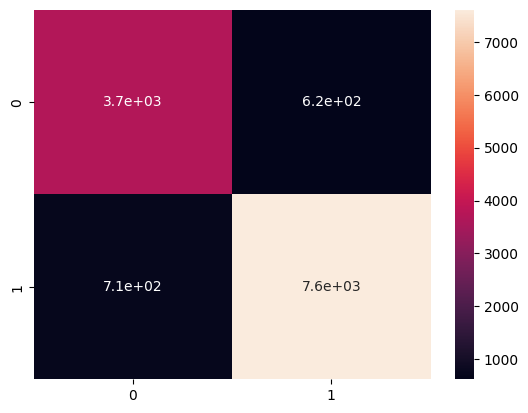

In [ ]:
rf = RandomForestClassifier(n_estimators= 200)

rf.fit(X_train,y_train)

y1_pred = rf.predict(X_test)

mostrar_metricas(y_test,y1_pred)

Accuracy:  0.8949283962338792

F1-score:  0.8952222479872525

AUROC: 0.8861662792960503

Matriz de confusión:


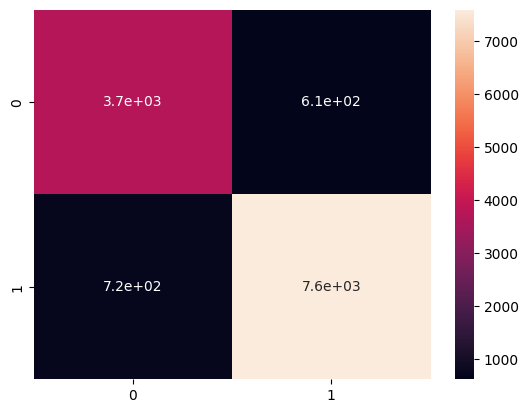

In [56]:
rf = RandomForestClassifier(n_estimators= 300)

rf.fit(X_train,y_train)

y1_pred = rf.predict(X_test)

mostrar_metricas(y_test,y1_pred)